In [54]:
import os
import sys
import datetime
import glob as glob
import numpy as np
import cv2
import keras
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers, models

In [76]:
# default settings
img_width, img_height = 224, 224

train_dir = 'Polyp_copy/train'
validate_dir = 'Polyp_copy/validation'
nb_classes = len(glob.glob(train_dir + '/*'))
epochs = 20
batch_size = 32

In [56]:
# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_train_samples)

300


In [57]:
# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_validate_samples)

100


In [58]:
# data pre-processing for training
train_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [59]:
# data pre-processing for validation
validate_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [60]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 300 images belonging to 2 classes.


In [61]:
# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 100 images belonging to 2 classes.


In [62]:
vgg_model = VGG16(include_top=False, weights = 'imagenet', input_shape = (img_height, img_width, 3))

In [63]:
for layer in vgg_model.layers:
    layer.trainable = False

In [65]:
x = layers.Flatten()(vgg_model.output)
prediction = layers.Dense(2, activation='softmax')(x)
model2 = Model(inputs = vgg_model.input, outputs=prediction)

In [66]:
model2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [67]:
model2.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [77]:
r = model2.fit(
 train_generator,
 validation_data=validate_generator,
 epochs=epochs,
)

Epoch 1/20
10/10 [==============================] - 7s 718ms/step - loss: 0.4028 - accuracy: 0.8033 - val_loss: 0.4494 - val_accuracy: 0.8000
Epoch 2/20
10/10 [==============================] - 7s 695ms/step - loss: 0.3658 - accuracy: 0.8267 - val_loss: 0.3767 - val_accuracy: 0.8600
Epoch 3/20
10/10 [==============================] - 7s 705ms/step - loss: 0.3456 - accuracy: 0.8500 - val_loss: 0.4189 - val_accuracy: 0.8300
Epoch 4/20
10/10 [==============================] - 7s 702ms/step - loss: 0.3150 - accuracy: 0.8800 - val_loss: 0.4664 - val_accuracy: 0.7900
Epoch 5/20
10/10 [==============================] - 7s 702ms/step - loss: 0.3608 - accuracy: 0.8367 - val_loss: 0.3879 - val_accuracy: 0.8300
Epoch 6/20
10/10 [==============================] - 7s 713ms/step - loss: 0.3162 - accuracy: 0.8600 - val_loss: 0.3281 - val_accuracy: 0.8600
Epoch 7/20
10/10 [==============================] - 7s 711ms/step - loss: 0.3242 - accuracy: 0.8667 - val_loss: 0.3610 - val_accuracy: 0.8300
Epoch 

In [85]:
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']

loss = r.history['loss']
val_loss = r.history['val_loss']


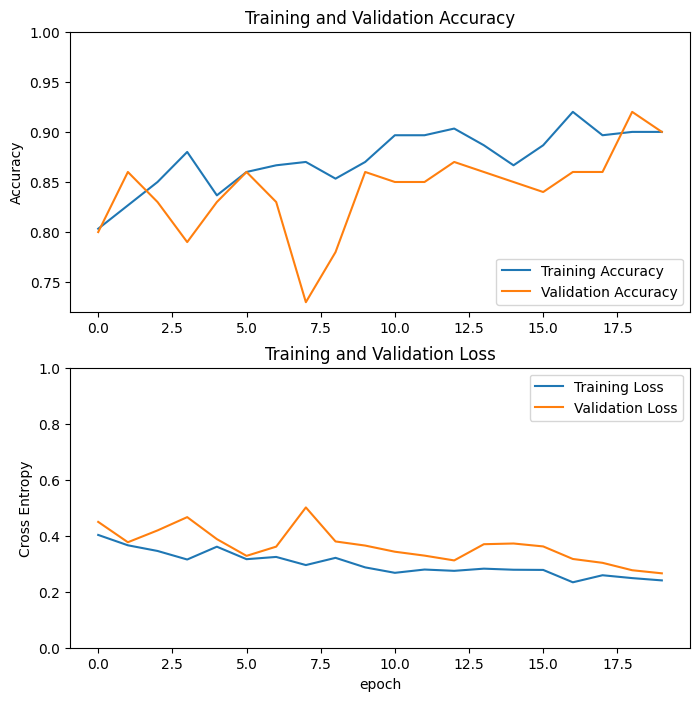

In [86]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [78]:
# Fine-tuning - only change weights for last layer
fine_tune_at = len(model2.layers) - 1
for layer in model2.layers[:fine_tune_at]:
    layer.trainable = False

In [80]:
model2.compile(loss='categorical_crossentropy'),
              optimizer = 'Adam',
              metrics=['accuracy'])

In [81]:
fine_tune_epochs = 20
total_epochs = epochs + fine_tune_epochs
history_fine = model2.fit(train_generator,
                             epochs=total_epochs,
                             initial_epoch=r.epoch[-1],
                             validation_data=validate_generator)

Epoch 20/40


2022-10-25 01:03:39.673118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.7395 - accuracy: 0.5667

2022-10-25 01:03:45.711225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 8s 798ms/step - loss: 0.7395 - accuracy: 0.5667 - val_loss: 0.6186 - val_accuracy: 0.7200
Epoch 21/40
10/10 [==============================] - 8s 776ms/step - loss: 0.5297 - accuracy: 0.7567 - val_loss: 0.5414 - val_accuracy: 0.7100
Epoch 22/40
10/10 [==============================] - 8s 824ms/step - loss: 0.4846 - accuracy: 0.7333 - val_loss: 0.4753 - val_accuracy: 0.8100
Epoch 23/40
10/10 [==============================] - 8s 799ms/step - loss: 0.4341 - accuracy: 0.7900 - val_loss: 0.4482 - val_accuracy: 0.7800
Epoch 24/40
10/10 [==============================] - 8s 800ms/step - loss: 0.4282 - accuracy: 0.7767 - val_loss: 0.4669 - val_accuracy: 0.7800
Epoch 25/40
10/10 [==============================] - 8s 791ms/step - loss: 0.3587 - accuracy: 0.8267 - val_loss: 0.4266 - val_accuracy: 0.8000
Epoch 26/40
10/10 [==============================] - 8s 821ms/step - loss: 0.3726 - accuracy: 0.8267 - val_loss: 0.3964 - val_accuracy: 0.8000
Epoch 27/40

In [87]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


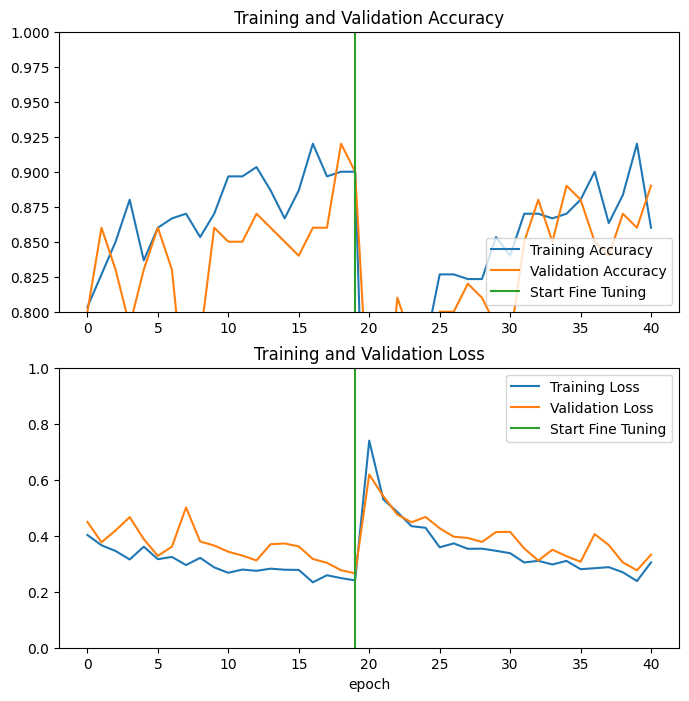

In [89]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [93]:
loss, accuracy = model2.evaluate(validate_generator)
print('Test accuracy :', accuracy)

4/4 [==============================] - 2s 371ms/step - loss: 0.2964 - accuracy: 0.8500
Test accuracy : 0.8499999642372131
